In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from google.colab import files

# Load dataset
uploaded = files.upload()
df = pd.read_csv('final_preprocessed_dataset.csv')

# Drop duplicate column
df = df.drop('History of Mental Illness_Yes', axis=1)

# Feature selection: Use SelectKBest with ANOVA for MLP
X_temp = df.drop('Target', axis=1)
y = df['Target']
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_temp, y)
selected_features = X_temp.columns[selector.get_support()].tolist()
print("Selected features for MLP:", selected_features)

X = df[selected_features]

# Display info
print("Dataset Shape:", df.shape)
print("Dataset Head:\n", df.head())
print("Dataset Info:")
df.info()

print("Target Distribution:\n", y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Saving final_preprocessed_dataset.csv to final_preprocessed_dataset.csv
Selected features for MLP: ['Age', 'Income', 'Education Level', 'Sleep Patterns', 'Physical Activity Level', 'Alcohol Consumption', 'Dietary Habits', 'Smoking Status', 'Employment Status', 'LFI']
Dataset Shape: (249450, 16)
Dataset Head:
         Age  Number of Children    Income  Education Level  Sleep Patterns  \
0  1.596498            1.378132 -1.226097              2.0             1.0   
1 -1.096950            0.569403 -0.186166              0.0             0.0   
2 -0.767140           -1.048056 -0.452160              0.0             2.0   
3 -0.107520           -1.048056 -0.574881              2.0             2.0   
4 -1.536697           -0.239327 -0.681067              0.0             1.0   

   Physical Activity Level  Alcohol Consumption  Dietary Habits  \
0                      1.0                  1.0             1.0   
1                      1.0                  1.0             0.0   
2                  

Base Model CV Results:
Accuracy: 0.5690 ± 0.0021
Precision: 0.5757 ± 0.0114
Recall: 0.5331 ± 0.0555
F1: 0.5514 ± 0.0257
Roc_auc: 0.5943 ± 0.0043


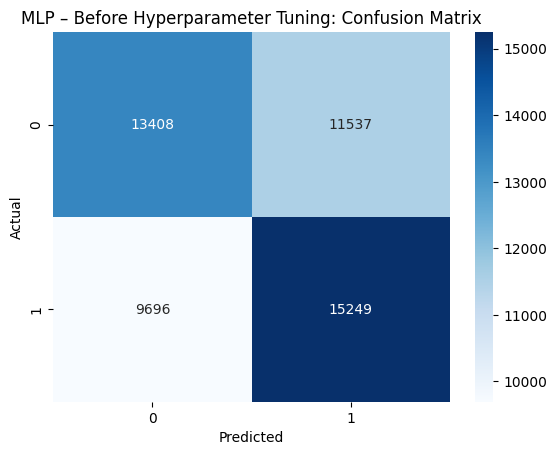

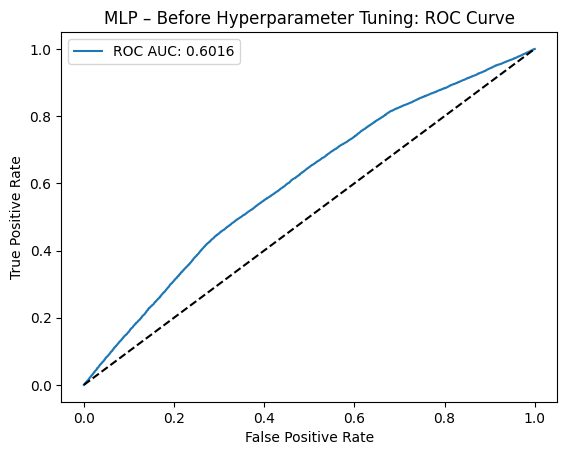

In [ ]:
model = MLPClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("Base Model CV Results:")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean():.4f} ± {cv_results['test_' + metric].std():.4f}")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('MLP – Before Hyperparameter Tuning: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('MLP – Before Hyperparameter Tuning: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Best CV F1 Score: 0.570815327753733
Tuned Model Test Results:
Accuracy: 0.5766486269793546
Precision: 0.5905388767875746
Recall: 0.4999398677089597
F1 Score: 0.5414758048759308
ROC AUC: 0.6019793973681364


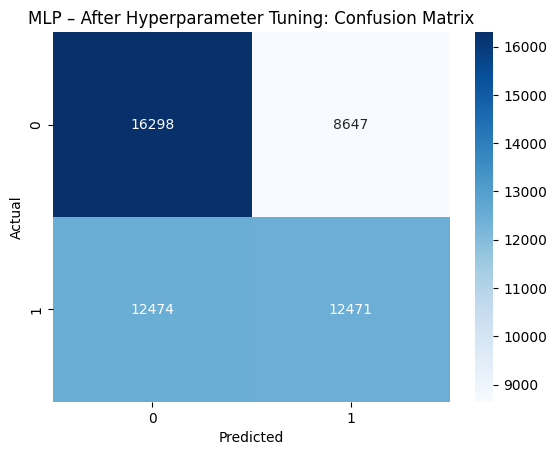

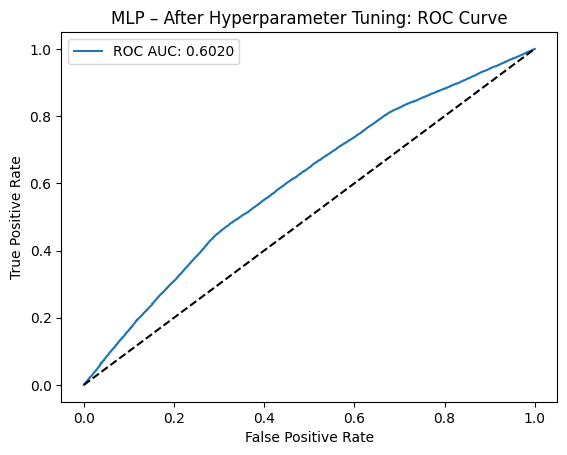

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001]
}
grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Tuned Model Test Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('MLP – After Hyperparameter Tuning: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('MLP – After Hyperparameter Tuning: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()